## Customer Life Time Value Research 

### 1987 COUNTING YOUR CUSTOMERS: WHO ARE THEY AND WHAT WILL THEY DO NEXT?

#### Practice



In [77]:
import pandas as pd
import numpy as np
import os
import plotly as plt

%matplotlib inline

try:
    

    df = pd.read_excel('/Users/rajeshpillai/Downloads/Online_Retail.xlsx',skiprows=0,header=0)

    df = df.dropna()

except:
    print('File Not Found')
    
# Add Total by multiplying Quantity and Unit Price

df['Total'] = df.Quantity*df.UnitPrice

# Change date format to YYYYMM

df['DateYMD'] = df.InvoiceDate.dt.strftime('%Y%m%d')

df['CustomerID'] =df['CustomerID'].astype('int')

df.head()



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,DateYMD
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,20101201
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20101201
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,20101201
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20101201
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20101201


In [78]:
df_rfm = df[['CustomerID','InvoiceDate','Total','Country']]

# Remove duplicates

df_rfm = df_rfm\
                .drop_duplicates() \
                .reset_index() 
                
df_rfm = df_rfm[df_rfm.Country=='United Kingdom']

df_rfm = df_rfm[['CustomerID','InvoiceDate','Total']]

df_rfm['InvoiceDate'] = pd.DatetimeIndex(df_rfm['InvoiceDate']).normalize()

    
df_rfm.head()



,CustomerID,InvoiceDate,Total
0,17850,2010-12-01,15.30
1,17850,2010-12-01,20.34
2,17850,2010-12-01,22.00
3,17850,2010-12-01,15.30
4,17850,2010-12-01,25.50


In [99]:
df_rfm[df_rfm.CustomerID==12748].Total.sum()

21141.559999999998

In [91]:
len(df_rfm[df_rfm.CustomerID==12748].InvoiceDate.unique())

115

In [79]:
import lifetimes as lt

rfm = lt.utils.summary_data_from_transaction_data(df_rfm, customer_id_col='CustomerID', 
                                            datetime_col='InvoiceDate',datetime_format='yyyy-mm-dd',
                                            monetary_value_col='Total')

# Remove single purchase customers

#rfm = rfm[rfm.frequency>0]

# Remove non zero monetary values

#rfm = rfm[rfm.monetary_value >0]

rfm.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.00000
12747,10.0,367.0,369.0,346.17300
12748,114.0,373.0,373.0,185.40886
12749,6.0,210.0,213.0,301.04000
12820,3.0,323.0,326.0,158.60000


In [85]:
114*185

21090

## Basic Frequency/Recency analysis using the BG/NBD model



In [66]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)

bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

print(bgf)

bgf.summary

<lifetimes.BetaGeoFitter: fitted with 3950 subjects, a: 0.02, alpha: 56.49, b: 0.61, r: 0.85>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.848838,0.027887,0.794179,0.903497
alpha,56.489831,2.238704,52.101971,60.877692
a,0.024294,0.007457,0.009678,0.038910
b,0.605477,0.237233,0.140501,1.070454


### Visualizing our Frequency/Recency Matrix

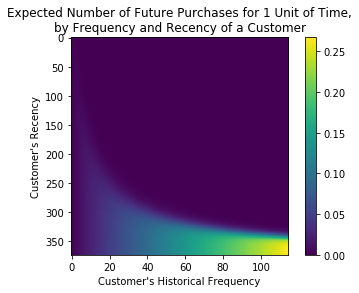

In [67]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

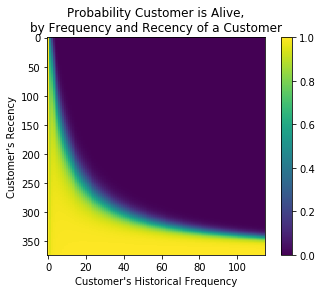

In [68]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

### Ranking customers from best to worst



In [70]:
t = 5

rfm['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'],
                                                                                     rfm['recency'], rfm['T'])

rfm.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
13089,82.0,367.0,369.0,480.442683,0.973002
14606,88.0,372.0,373.0,105.432159,1.033853
15311,90.0,373.0,373.0,462.552333,1.057199
17841,112.0,372.0,373.0,247.672411,1.313196
12748,114.0,373.0,373.0,185.408860,1.336562


### Assessing model fit

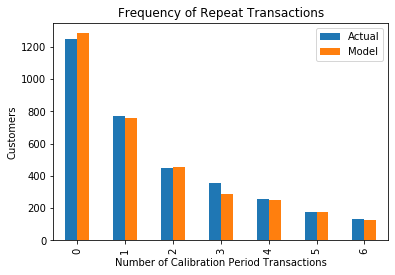

In [71]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

### Calibration and Holdout set

In [95]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df_rfm, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-09-30',
                                        observation_period_end='2011-12-09' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,255.0,0.0,70
12747,7.0,260.0,299.0,3.0,70
12748,80.0,303.0,303.0,34.0,70
12749,4.0,100.0,143.0,2.0,70
12820,1.0,252.0,256.0,2.0,70


/Users/rajeshpillai/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning:

invalid value encountered in log



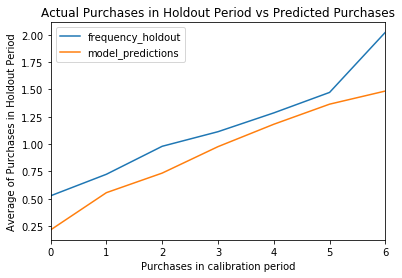

In [96]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

The graph diverges beyond purchase 5 and more. Need further study on this aspect

### The Gamma-Gamma model and the independence assumption

In [53]:
# Remove single purchase customers

rfm = rfm[rfm.frequency>0]

# Remove non zero monetary values

rfm = rfm[rfm.monetary_value >0]

rfm.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747,10.0,367.0,369.0,346.17300
12748,114.0,373.0,373.0,185.40886
12749,6.0,210.0,213.0,301.04000
12820,3.0,323.0,326.0,158.60000
12822,2.0,17.0,87.0,76.21500


In [54]:
#from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = rfm
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())


            frequency  recency      T  monetary_value
CustomerID                                           
12747            10.0    367.0  369.0       346.17300
12748           114.0    373.0  373.0       185.40886
12749             6.0    210.0  213.0       301.04000
12820             3.0    323.0  326.0       158.60000
12822             2.0     17.0   87.0        76.21500


In [55]:
returning_customers_summary.tail()

,frequency,recency,T,monetary_value
CustomerID,,,,
18273,2.0,255.0,257.0,76.500000
18277,1.0,260.0,318.0,92.530000
18282,2.0,119.0,126.0,38.195000
18283,13.0,334.0,337.0,63.513846
18287,2.0,159.0,201.0,331.940000


In [56]:
## The Gamma-Gamma model and the independence assumption

returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.174887
frequency,0.174887,1.000000


In [82]:
returning_customers_summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12747,10.0,367.0,369.0,346.17300
12748,114.0,373.0,373.0,185.40886
12749,6.0,210.0,213.0,301.04000
12820,3.0,323.0,326.0,158.60000
12822,2.0,17.0,87.0,76.21500


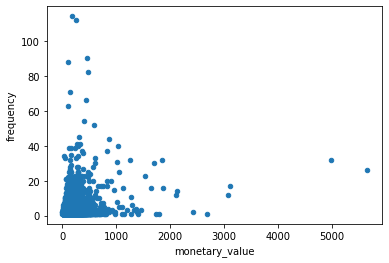

In [76]:
returning_customers_summary.plot(x='monetary_value',
                                 y='frequency',
                                kind='scatter')

In [ ]:
plt.plot

In [58]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2526 subjects, p: 1.52, q: 4.23, v: 488.25>


In [97]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

CustomerID
12747    325.681366
12748    186.215161
12749    282.282155
12820    187.984320
12822    155.190286
12823    316.846738
12826    116.885343
12827    162.522490
12828    161.230823
12829    158.792198
dtype: float64


In [98]:
rfm.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.00000
12747,10.0,367.0,369.0,346.17300
12748,114.0,373.0,373.0,185.40886
12749,6.0,210.0,213.0,301.04000
12820,3.0,323.0,326.0,158.60000


In [60]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 234.3898761606206, Average profit: 227.88418141083775


In [108]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.00 # monthly discount rate ~ 12.7% annually
).head(10))


CustomerID
12747     2986.626789
12748    16623.062194
12749     2580.027675
12820      770.328906
12822     1063.420494
12823     1657.691122
12826      806.008424
12827     1605.624493
12828     1762.562221
12829      153.606558
Name: clv, dtype: float64


In [ ]:
12747     3461.73
12748    21136.61
12749     1806.24
12820      475.80

In [169]:
from lifetimes import ParetoNBDFitter

pnf = ParetoNBDFitter()

pnf.fit(rfm['frequency'],
        rfm['recency'],
        rfm['T']
       )

print(pnf)

<lifetimes.ParetoNBDFitter: fitted with 2526 subjects, alpha: 89.49, beta: 993.34, r: 1.79, s: 0.04>


In [176]:
ggf.customer_lifetime_value(pnf,rfm['frequency'],
        rfm['recency'],
        rfm['T'],
        rfm['monetary_value']).head()

CustomerID
12747     2814.846072
12748    15667.193825
12749     2442.201177
12820      728.557991
12822     1111.072964
Name: clv, dtype: float64

In [12]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter()

bgf.fit(rfm['frequency'],
        rfm['recency'],
        rfm['T']
       )

print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2526 subjects, a: 0.04, alpha: 88.75, b: 1.19, r: 1.85>


In [179]:
ggf.customer_lifetime_value(bgf,rfm['frequency'],
        rfm['recency'],
        rfm['T'],
        rfm['monetary_value']).head()

CustomerID
12747     2801.857972
12748    15594.343526
12749     2420.626598
12820      722.710656
12822      997.887461
Name: clv, dtype: float64